In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import shutil
import os
import random
import cv2
import math
import json
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


import keras
from keras.preprocessing.image import *
from keras.models import Sequential, Model
from keras.layers import Convolution2D, Flatten, Lambda, MaxPooling2D, Cropping2D, AveragePooling2D,BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from IPython.display import display # Allows the use of display() for DataFrames

# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_dir = 'data'
columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv(data_dir + '/driving_log.csv', header=None, names=columns)
data.iloc[:5]

,center,left,right,steering_angle,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
print("Data loaded...")
print("Dataset Columns:", columns, "\n")
print("Shape of the dataset:", data.shape, "\n")
print(data.describe(), "\n")

Data loaded...
Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

Shape of the dataset: (8036, 7) 

       steering_angle     throttle        brake        speed
count     8036.000000  8036.000000  8036.000000  8036.000000
mean         0.004070     0.869660     0.001970    28.169839
std          0.128840     0.301326     0.036565     6.149327
min         -0.942695     0.000000     0.000000     0.502490
25%          0.000000     0.985533     0.000000    30.183093
50%          0.000000     0.985533     0.000000    30.186400
75%          0.000000     0.985533     0.000000    30.186640
max          1.000000     0.985533     1.000000    30.709360 



(160, 320, 3)


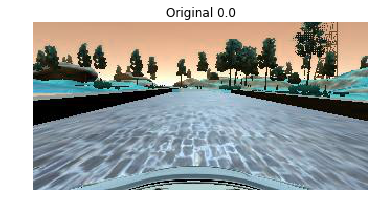

In [4]:
def read_image(file):
    # Readimage from file
    image = cv2.imread('data/' + file)
    return image

def showImage(image, title):
    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.title(title)
    plt.imshow(image)
    plt.show()

image = read_image(data['center'][0].strip())
print(image.shape)

showImage(image, 'Original ' + str(data['steering_angle'][0]) ) 

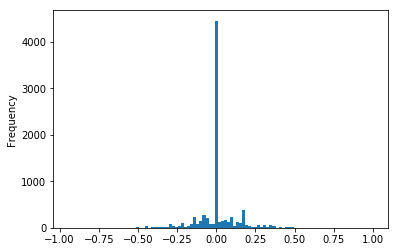

In [5]:
data['steering_angle'].plot.hist(bins=100)

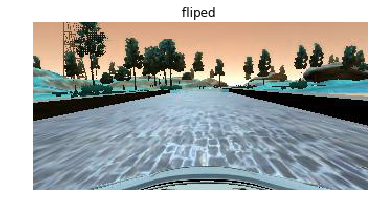

In [6]:
# flip images horizontally
def horizontal_flip(img):
    flipped_image = cv2.flip(img, 1)
    return flipped_image

fliped = horizontal_flip(image)
showImage(fliped, 'fliped ')


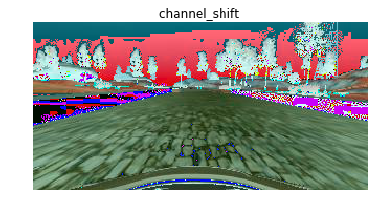

In [7]:
CHANNEL_SHIFT_RANGE = 0.2
# shift range for each channels
def channel_shift(img, channel_shift_range=CHANNEL_SHIFT_RANGE):
    img_channel_index = 2 # tf indexing
    channel_shifted_image = random_channel_shift(img, channel_shift_range, img_channel_index)
    return channel_shifted_image

channel_shift = channel_shift(image)
showImage(channel_shift, 'channel_shift ')

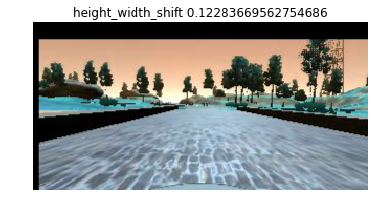

In [8]:
WIDTH_SHIFT_RANGE = 100
HEIGHT_SHIFT_RANGE = 40

def height_width_shift(img, steering_angle):
    rows, cols, channels = img.shape
    
    # Translation
    tx = WIDTH_SHIFT_RANGE * np.random.uniform() - WIDTH_SHIFT_RANGE / 2
    ty = HEIGHT_SHIFT_RANGE * np.random.uniform() - HEIGHT_SHIFT_RANGE / 2
    steering_angle = steering_angle + tx / WIDTH_SHIFT_RANGE * 2 * .2
    
    transform_matrix = np.float32([[1, 0, tx],
                                   [0, 1, ty]])
    
    translated_image = cv2.warpAffine(img, transform_matrix, (cols, rows))
    return translated_image, steering_angle

translated_image, steering_angle = height_width_shift(image, 0.1)
showImage(translated_image, 'height_width_shift ' + str(steering_angle))

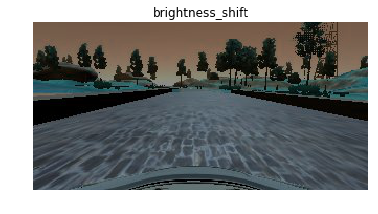

In [9]:
def brightness_shift(img, bright_value=None):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if bright_value:
        img[:,:,2] += bright_value
    else:
        random_bright = .25 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

brightness_shift = brightness_shift(image)
showImage(brightness_shift, 'brightness_shift')

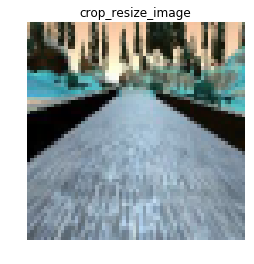

In [10]:
# processed image variables
PROCESSED_IMG_COLS = 64
PROCESSED_IMG_ROWS = 64

def crop_resize_image(img):
    shape = img.shape
    img = img[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img, (PROCESSED_IMG_COLS, PROCESSED_IMG_ROWS), interpolation=cv2.INTER_AREA)    
    return img


crop_resize_image = crop_resize_image(image)
showImage(crop_resize_image, 'crop_resize_image')

In [11]:
def apply_random_transformation(img, steering_angle):
    
    transformed_image, steering_angle = height_width_shift(img, steering_angle)
    transformed_image = brightness_shift(transformed_image)
    # transformed_image = channel_shift(transformed_image) # increasing train time. not much benefit. commented
    
    if np.random.random() < 0.5:
        transformed_image, steering_angle = horizontal_flip(transformed_image, steering_angle)
            
    transformed_image = crop_resize_image(transformed_image)
    
    return transformed_image, steering_angle

# apply_random_transformation(image, 0.1)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
CAMARA_ANGLE = 0.3


def preprozess_line(line_data, training=False):
    x, y = [], []
    y_steer = line_data['steering_angle']
    path_center = line_data['center'].strip()
    path_left = line_data['left'].strip()
    path_right = line_data['right'].strip()
    
    if training:
        img_paths = [(path_center, 0), (path_left, CAMARA_ANGLE), (path_right, -CAMARA_ANGLE)]
    else:
        img_paths = [(path_center, 0)]
        
    for path, shift in img_paths:
        # read image
        image_path = os.path.join(data_dir, path)
        image = cv2.imread(image_path)

        # add image
        x.append(image)
        y.append(y_steer + shift)
        if(training):
            # add flipped image
            image = horizontal_flip(image)
            x.append(image)
            y.append(-(y_steer + shift))

    return np.array(x), np.array(y)

line_data = data.iloc[0]
X_gen, Y_gen = preprozess_line(line_data)


In [ ]:
# Number of training examples
n_X_gen = len(X_gen)

# Number of testing examples.
n_Y_gen = len(Y_gen)

# What's the shape of an traffic sign image?
image_shape = X_gen[0].shape

print("Number of line images =", n_X_gen)
print("Number of line labels =", n_Y_gen)
print("labels =", Y_gen)
print("Image data shape =", image_shape)

In [ ]:
data_train, data_val = train_test_split(data, test_size=0.2)

In [ ]:
# Number of training examples
n_train = len(data_train)

# Number of testing examples.
n_val = len(data_val)

print("Number of train images =", n_train)
print("Number of n_val labels =", n_val)

In [ ]:
MODEL_IMG_CHANNELS = 3

def nvidia_model(summary=False):
    
    model = Sequential()
    # Crop the sky and bottom pixels, normalise and reduce dimensionality
    model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=[160, 320, 3]))
    #model.add(Cropping2D(((80,25),(1,1)), name="Crop2D"))
    #model.add(BatchNormalization(axis=1, name="Normalise"))
    #model.add(AveragePooling2D(pool_size=(1,4), name="Resize", trainable=False))

    # Successively learn through multiple convolutions, relu activations and pooling layers,
    model.add(Convolution2D(24, (3, 3), strides=(2,2), name="Conv1", activation="relu"))
    model.add(MaxPooling2D(name="MaxPool1"))
    model.add(Convolution2D(48, (3, 3), strides=(1,1), name="Conv2", activation="relu"))
    model.add(MaxPooling2D(name="MaxPool2"))
    model.add(Convolution2D(72, (3, 3), strides=(1,1), name="Conv3", activation="relu"))
    model.add(MaxPooling2D(name="MaxPool3"))
    model.add(Dropout(0.2, name="Dropout1"))

    # Learn the steering angles through 3 fully connected layers
    model.add(Flatten(name="Flatten"))
    model.add(Dense(100, activation="relu", name="FC2"))
    model.add(Dropout(0.5, name="Dropout2"))

    model.add(Dense(50, activation="relu", name="FC3"))
    model.add(Dropout(0.5, name="Dropout3"))

    model.add(Dense(10, activation="relu", name="FC4"))
    model.add(Dropout(0.5, name="Dropout4"))

    # Final Output  of steering angles
    model.add(Dense(1, name="Steering", activation='linear'))


    if summary:
        model.summary()
    return model

def _nvidia_model(summary=False):
    
    model = Sequential()
    model.add(Flatten(name="Flatten", input_shape=[160, 320, 3]))
    model.add(Dense(1, name="Steering"))
              
    return model

model = nvidia_model(True)

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='mse')

In [ ]:
def generator(records, batch_size=32, training=False):
    while True:
        num_records = len(records)
        filter_indices = np.random.randint(0, num_records, batch_size)
        images =[]
        angles = []
        for line_indice in filter_indices:
            line =  data.iloc[line_indice]
            X_gen, Y_gen = preprozess_line(line, training);
            images.extend(X_gen)
            angles.extend(Y_gen)

        X = np.array(images)
        y = np.array(angles)

        # output a batch increment
        yield X, y

gen = generator( data_val, batch_size=1)        
x, y = next( gen )
print(y)     

gen = generator( data_val, batch_size=1, training=True)        
x, y = next( gen )
print(y)     
showImage(x[0], 'Test' ) 


In [ ]:
gen_train = generator(data_train, training=True)  
gen_val = generator(data_val)

In [ ]:
nb_epoch = 8
nb_samples_per_epoch = 20000
nb_val_samples = 1000
learning_rate = 1e-4

history_object = model.fit(x, y, validation_split=0.2, shuffle=True)

In [ ]:
model.save("model.h5")
print("Saved model")

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
image_array = np.asarray(x[0])
steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
print(steering_angle)
print(y[0])